In [38]:
import pandas as pd
from torch.utils.data import Dataset
from typing import Optional, List, TypeVar, Union
from pathlib import Path
from torch.utils.data import Dataset
import rasterio
from tqdm import tqdm
import numpy as np
import cv2
import warnings
from segmentation.config import Configs as CFG
from segmentation.scr.rle_coding import *
from segmentation.scr.tilling_loader import random_sub_df
import matplotlib.pyplot as plt
import albumentations as A


PandasDataFrame = TypeVar('pandas.core.frame.DataFrame')

In [4]:
df = pd.read_csv(CFG.path_df_kidney_1_til)

In [5]:
class Tilling_loader(Dataset):
    """Creating a dataloader for image tiling
    """

    def __init__(self,
                 name_data: str,
                 path_to_df: str,
                 use_random_sub: bool = False,
                 empty_tile_pct: int = 0,
                 sample_limit :Optional[int] = None,
                 transform=None

                 ):
        super().__init__()
        self.name_data = name_data
        self.path_to_df = Path(path_to_df)
        self.use_random_sub = use_random_sub
        self.empty_tile_pct = empty_tile_pct
        self.sample_limit = sample_limit
        self.transform = transform

        df = pd.read_csv(self.path_to_df)
        if self.use_random_sub:
            self.df = random_sub_df(df=df, sample_limit=self.sample_limit,
                                    empty_tile_pct=self.empty_tile_pct)
        else:
            self.df = df

    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, idx) -> tuple:
        img_path, lb_path, is_empty, bbx, px_stats, size = self.df.iloc[idx, :].values

        return img_path, lb_path, is_empty, bbx, px_stats, size


data_loader = Tilling_loader(
    name_data='kidney_1_tilling',
    path_to_df='data\\kidney_1_tilling.csv',
    use_random_sub=True,
    empty_tile_pct=10,
    sample_limit=20
)

20
Dataset contains 1528 empty and 12146 non-empty tiles.
Sample 2 empty and 18 non-empty tiles.


In [6]:
data_loader.df['is_empty'].value_counts(normalize=True)

is_empty
False    0.9
True     0.1
Name: proportion, dtype: float64

In [217]:
for i in range(len(data_loader)):
    x = data_loader[i]

In [218]:
img_path, lb_path, is_empty, bbx, px_stats, size = data_loader[i]

In [219]:
gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
img = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) #(H,W ,C)
mask = cv2.imread(lb_path, cv2.IMREAD_GRAYSCALE).astype('float32') / 255.0        



In [235]:
p_rot = 1
train_transform = A.Compose([
            A.Transpose(p=p_rot),
              A.VerticalFlip(p=p_rot),
              A.HorizontalFlip(p=p_rot),
              A.ElasticTransform(alpha=120, sigma=160 * 0.05, alpha_affine=5, p=1),
              A.RandomBrightnessContrast(p=1),
              #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=25, border_mode=0, p=1),
              #A.GaussNoise(p=1, var_limit=[10, 50])
              #A.GaussianBlur(p=1)
              #A.ElasticTransform(alpha=120, sigma=160 * 0.05, alpha_affine=5, p=1)
              
              
]
             )
            #A.Transpose(p=1
        

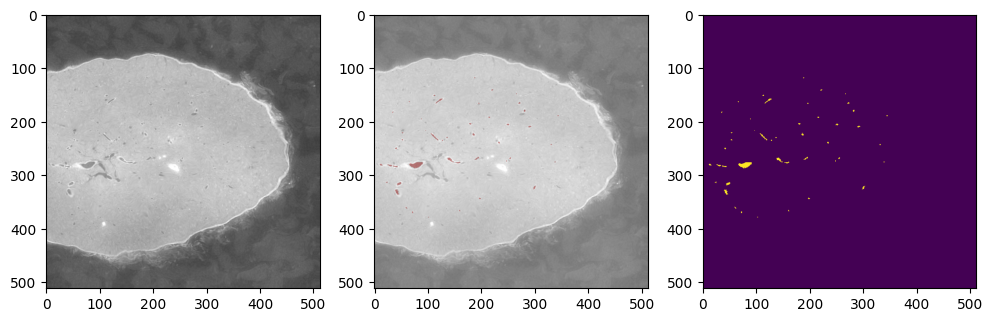

In [241]:
from skimage import color
gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
img = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) #(H,W ,C)
mask = cv2.imread(lb_path, cv2.IMREAD_GRAYSCALE).astype('float32') / 255.0   
augmented = train_transform(image=img,mask=mask)
img,mask = augmented['image'],augmented['mask']

fig, axarr = plt.subplots(ncols=3, figsize=(12, 6))
axarr[0].imshow(img, cmap="gray")
axarr[1].imshow(color.label2rgb(mask, img, bg_label=0, bg_color=(1.,1.,1.), alpha=0.25))
axarr[2].imshow(mask, vmin=0, interpolation='antialiased', interpolation_stage='rgba')

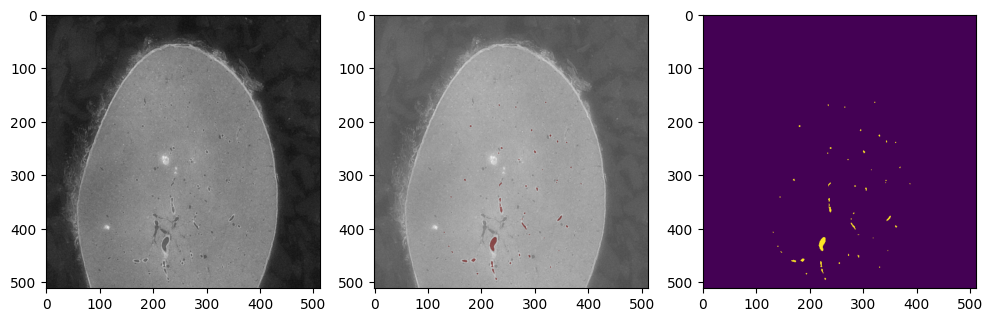

In [239]:
from skimage import color
gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
img = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) #(H,W ,C)
mask = cv2.imread(lb_path, cv2.IMREAD_GRAYSCALE).astype('float32') / 255.0   
#augmented = train_transform(image=img,mask=mask)
#img,mask = augmented['image'],augmented['mask']

fig, axarr = plt.subplots(ncols=3, figsize=(12, 6))
axarr[0].imshow(img, cmap="gray")
axarr[1].imshow(color.label2rgb(mask, img, bg_label=0, bg_color=(1.,1.,1.), alpha=0.25))
axarr[2].imshow(mask, vmin=0, interpolation='antialiased', interpolation_stage='rgba')

In [82]:
img.shape

(512, 512, 3)

In [27]:
img.shape

(512, 512, 3)

In [15]:
img[None, :,:].shape

(1, 512, 512)

In [21]:
gray = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
#img1 = np.tile(img1[...,None], [1, 1, 3]) 
backtorgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

In [23]:
backtorgb.shape

(512, 512, 3)

In [8]:
data_loader.df

,path_img,path_lb,is_empty,bbx,px_stats,size
650,data\kidney_1_tilling\images\0108_0_395_512_51...,data\kidney_1_tilling\labels\0108_0_395_512_51...,False,"(0, 395, 512, 512)","[19352, 39506]","(1303, 912)"
1793,data\kidney_1_tilling\images\0298_400_791_512_...,data\kidney_1_tilling\labels\0298_400_791_512_...,True,"(400, 791, 512, 512)","[18907, 34296]","(1303, 912)"
3284,data\kidney_1_tilling\images\0547_0_395_512_51...,data\kidney_1_tilling\labels\0547_0_395_512_51...,False,"(0, 395, 512, 512)","[18573, 64941]","(1303, 912)"
3373,data\kidney_1_tilling\images\0562_400_0_512_51...,data\kidney_1_tilling\labels\0562_400_0_512_51...,False,"(400, 0, 512, 512)","[17886, 64367]","(1303, 912)"
3545,data\kidney_1_tilling\images\0590_400_791_512_...,data\kidney_1_tilling\labels\0590_400_791_512_...,False,"(400, 791, 512, 512)","[17763, 40842]","(1303, 912)"
3639,data\kidney_1_tilling\images\0606_400_395_512_...,data\kidney_1_tilling\labels\0606_400_395_512_...,False,"(400, 395, 512, 512)","[18596, 63544]","(1303, 912)"
3710,data\kidney_1_tilling\images\0618_0_395_512_51...,data\kidney_1_tilling\labels\0618_0_395_512_51...,False,"(0, 395, 512, 512)","[18582, 37028]","(1303, 912)"
4733,data\kidney_1_tilling\images\0788_400_791_512_...,data\kidney_1_tilling\labels\0788_400_791_512_...,False,"(400, 791, 512, 512)","[18534, 38651]","(1303, 912)"
5442,data\kidney_1_tilling\images\0907_0_0_512_512.png,data\kidney_1_tilling\labels\0907_0_0_512_512.png,False,"(0, 0, 512, 512)","[19035, 37953]","(1303, 912)"
5789,data\kidney_1_tilling\images\0964_400_791_512_...,data\kidney_1_tilling\labels\0964_400_791_512_...,False,"(400, 791, 512, 512)","[18920, 32989]","(1303, 912)"


In [32]:
len(data_loader)

13674

In [ ]:
    name_data='kidney_1_tilling',
    strong_empty=False,
    path_img_dir=CFG.path_img_kidney1,
                         path_lb_dir=CFG.path_lb_kidney1,
                         cache_dir=CFG.cache_dir 

In [9]:
type(pd.DataFrame())

pandas.core.frame.DataFrame

In [16]:
new_df['is_empty'].value_counts(normalize=True)

is_empty
False    0.960006
True     0.039994
Name: proportion, dtype: float64

In [105]:
df_empty = df[df['is_empty'] == True].sample(1000)
df_no_empty = df[df['is_empty'] == False].sample(6000)
frames = [df_empty, df_no_empty]
pd.concat(frames).sort_index()

,path_img,path_lb,is_empty,bbx,px_stats,size
2,data\kidney_1_tilling\images\0000_0_395_512_51...,data\kidney_1_tilling\labels\0000_0_395_512_51...,True,"(0, 395, 512, 512)","[18515, 36640]","(1303, 912)"
4,data\kidney_1_tilling\images\0000_0_791_512_51...,data\kidney_1_tilling\labels\0000_0_791_512_51...,True,"(0, 791, 512, 512)","[18515, 36640]","(1303, 912)"
5,data\kidney_1_tilling\images\0000_400_791_512_...,data\kidney_1_tilling\labels\0000_400_791_512_...,True,"(400, 791, 512, 512)","[18515, 36640]","(1303, 912)"
6,data\kidney_1_tilling\images\0001_0_0_512_512.png,data\kidney_1_tilling\labels\0001_0_0_512_512.png,True,"(0, 0, 512, 512)","[18320, 37358]","(1303, 912)"
8,data\kidney_1_tilling\images\0001_0_395_512_51...,data\kidney_1_tilling\labels\0001_0_395_512_51...,True,"(0, 395, 512, 512)","[18320, 37358]","(1303, 912)"
...,...,...,...,...,...,...
13668,data\kidney_1_tilling\images\2278_0_0_512_512.png,data\kidney_1_tilling\labels\2278_0_0_512_512.png,True,"(0, 0, 512, 512)","[10069, 18379]","(1303, 912)"
13669,data\kidney_1_tilling\images\2278_400_0_512_51...,data\kidney_1_tilling\labels\2278_400_0_512_51...,True,"(400, 0, 512, 512)","[10069, 18379]","(1303, 912)"
13671,data\kidney_1_tilling\images\2278_400_395_512_...,data\kidney_1_tilling\labels\2278_400_395_512_...,True,"(400, 395, 512, 512)","[10069, 18379]","(1303, 912)"
13672,data\kidney_1_tilling\images\2278_0_791_512_51...,data\kidney_1_tilling\labels\2278_0_791_512_51...,True,"(0, 791, 512, 512)","[10069, 18379]","(1303, 912)"


In [89]:
800 / 7200

0.1111111111111111

In [82]:
1528/ (1528+3565)

0.30001963479285293

In [55]:
empty_tiles = df[df['is_empty'] == True].index.values

In [ ]:
num_empty_tiles_to_sample 

In [ ]:
np.random.choice(empty_tiles, min(num_empty_tiles_to_sample, len(empty_tiles)), replace=False)

In [54]:
df[df['is_empty'] == True].index.values

array([    0,     1,     2, ..., 13671, 13672, 13673], dtype=int64)

In [37]:
df = pd.read_csv(CFG.path_df_kidney_1_til)

In [39]:
df['is_empty'].value_counts(normalize=True)[False]

0.8882550826385842

In [16]:
num_tiles = df.shape[0]
num_tiles 

13674

In [18]:
empty_tile_pct = 20
num_empty_tiles_to_sample = int(num_tiles * empty_tile_pct / 100)
num_pos_tiles_to_sample = int(num_tiles * (1 - empty_tile_pct / 100))

In [19]:
num_empty_tiles_to_sample

2734

In [20]:
num_pos_tiles_to_sample

10939

In [21]:
1367 + 12306

13673

In [31]:
np.random.choice(10, min(5, 4), replace=False)

array([3, 2, 7, 6])

In [ ]:
num_empty_tiles_to_sample = int(self.sample_limit * self.empty_tile_pct)
            num_pos_tiles_to_sample = int(self.sample_limit * (1 - self.empty_tile_pct))

            empty_idxs_to_sample = np.random.choice(len(empty_tiles), min(num_empty_tiles_to_sample, len(empty_tiles)), replace=False)
            pos_idxs_to_sample = np.random.choice(len(populated_tiles), min(num_pos_tiles_to_sample, len(populated_tiles)), replace=False)

            neg_samples = list(map(empty_tiles.__getitem__, empty_idxs_to_sample))
            pos_samples = list(map(populated_tiles.__getitem__, pos_idxs_to_sample))

            new_samples = pos_samples + neg_samples

            self.samples = new_samples
            if self.empty_tile_pct == 0.0:
                print(f'Dropped {empty} empty tiles.')
            print(f'Dataset contains {len(neg_samples)} empty and {len(pos_samples)} non-empty tile

In [8]:
df

,path_img,path_lb,is_empty,bbx,px_stats,size
0,data\kidney_1_tilling\images\0000_0_0_512_512.png,data\kidney_1_tilling\labels\0000_0_0_512_512.png,True,"(0, 0, 512, 512)","[18515, 36640]","(1303, 912)"
1,data\kidney_1_tilling\images\0000_400_0_512_51...,data\kidney_1_tilling\labels\0000_400_0_512_51...,True,"(400, 0, 512, 512)","[18515, 36640]","(1303, 912)"
2,data\kidney_1_tilling\images\0000_0_395_512_51...,data\kidney_1_tilling\labels\0000_0_395_512_51...,True,"(0, 395, 512, 512)","[18515, 36640]","(1303, 912)"
3,data\kidney_1_tilling\images\0000_400_395_512_...,data\kidney_1_tilling\labels\0000_400_395_512_...,True,"(400, 395, 512, 512)","[18515, 36640]","(1303, 912)"
4,data\kidney_1_tilling\images\0000_0_791_512_51...,data\kidney_1_tilling\labels\0000_0_791_512_51...,True,"(0, 791, 512, 512)","[18515, 36640]","(1303, 912)"
...,...,...,...,...,...,...
13669,data\kidney_1_tilling\images\2278_400_0_512_51...,data\kidney_1_tilling\labels\2278_400_0_512_51...,True,"(400, 0, 512, 512)","[10069, 18379]","(1303, 912)"
13670,data\kidney_1_tilling\images\2278_0_395_512_51...,data\kidney_1_tilling\labels\2278_0_395_512_51...,True,"(0, 395, 512, 512)","[10069, 18379]","(1303, 912)"
13671,data\kidney_1_tilling\images\2278_400_395_512_...,data\kidney_1_tilling\labels\2278_400_395_512_...,True,"(400, 395, 512, 512)","[10069, 18379]","(1303, 912)"
13672,data\kidney_1_tilling\images\2278_0_791_512_51...,data\kidney_1_tilling\labels\2278_0_791_512_51...,True,"(0, 791, 512, 512)","[10069, 18379]","(1303, 912)"
